# Geometry computations Example 4: Slice animal videos on CPU

In this short notebook, we extract bounding boxes (cropped images of the animal) representing from the pose-estimation data. 

In [1]:
import os
from simba.mixins.config_reader import ConfigReader
from simba.mixins.geometry_mixin import GeometryMixin
from simba.mixins.image_mixin import ImageMixin
from simba.plotting.geometry_plotter import GeometryPlotter
from simba.utils.read_write import (get_video_meta_data, read_df)
from ipywidgets import Video
from IPython.display import HTML, Image
import matplotlib.pyplot as plt
import matplotlib 
dpi = matplotlib.rcParams['figure.dpi']
import cv2

In [2]:
#DEFINE PROJECT PATH, ANIMAL NAMES AND VIDEO NAME
CONFIG_PATH = "/Users/simon/Desktop/envs/simba/troubleshooting/RI/project_folder/project_config.ini"
VIDEO_NAME = "RI_01_165_clipped"
WHITE = "Animal_1"
BLACK = "Animal_2"

In [3]:
# READ IN DATA BASED ON THE ABOVE SPECIFICATIONS
config = ConfigReader(config_path=CONFIG_PATH, create_logger=False)
data_path = os.path.join(config.outlier_corrected_dir, f"{VIDEO_NAME}.{config.file_type}")
video_path = os.path.join(config.video_dir, f"{VIDEO_NAME}.mp4")
get_video_meta_data(video_path)
df = read_df(file_path=data_path, file_type=config.file_type)
resolution, pixels_per_mm, fps = config.read_video_info(video_name=VIDEO_NAME)

In [4]:
#EXTRACT THE WHITE AND BLACK ANIMAL POSE-ESTIMATION FROM THE DATA
white_animal_bp_names, black_animal_bp_names = (config.animal_bp_dict[WHITE], config.animal_bp_dict[BLACK])
white_animal_cols, black_animal_cols = [], []
for x, y in zip(white_animal_bp_names["X_bps"], white_animal_bp_names["Y_bps"]): white_animal_cols.extend((x, y))
for x, y in zip(black_animal_bp_names["X_bps"], black_animal_bp_names["Y_bps"]): black_animal_cols.extend((x, y))
white_animal_df, black_animal_df = df[white_animal_cols].astype(int), df[black_animal_cols].astype(int)
white_animal_df_arr = white_animal_df.values.reshape(len(white_animal_df), -1, 2)
black_animal_df_arr = black_animal_df.values.reshape(len(black_animal_df), -1, 2)

In [5]:
# EXTRACT THE ANIMAL SHAPES, AND FORCE THEM INTO RECTANGLES
white_animal_polygons = GeometryMixin().multiframe_bodyparts_to_polygon( data=white_animal_df_arr, pixels_per_mm=pixels_per_mm, parallel_offset=40, verbose=False, core_cnt=-1)
black_animal_polygons = GeometryMixin().multiframe_bodyparts_to_polygon( data=black_animal_df_arr, pixels_per_mm=pixels_per_mm, parallel_offset=40, verbose=False, core_cnt=-1)
white_animal_polygons = GeometryMixin().multiframe_minimum_rotated_rectangle(shapes=white_animal_polygons, verbose=False, core_cnt=-1)
black_animal_polygons = GeometryMixin().multiframe_minimum_rotated_rectangle(shapes=black_animal_polygons, verbose=False, core_cnt=-1)


SIMBA COMPLETE: Polygons complete. (elapsed time: 0.1495s) 	complete
SIMBA COMPLETE: Polygons complete. (elapsed time: 0.1904s) 	complete
SIMBA COMPLETE: Rotated rectangles complete. (elapsed time: 0.153s) 	complete
SIMBA COMPLETE: Rotated rectangles complete. (elapsed time: 0.1474s) 	complete


In [20]:
# IF WE WANT, THEN WE CAN VISUALIZE THE ANIMAL GEOMETRIES AS SLICED FROM THE VIDEO
white_animal_imgs = ImageMixin().slice_shapes_in_imgs(imgs=video_path, shapes=white_animal_polygons, verbose=False)
ImageMixin.img_stack_to_video(imgs=white_animal_imgs, 
                              save_path="/Users/simon/Desktop/envs/simba/troubleshooting/RI/project_folder/frames/output/stack/test.mp4", 
                              fps=fps,
                              verbose=False)

SIMBA COMPLETE: Geometry image slicing complete. (elapsed time: 1.5292s) 	complete


In [3]:
#TO VIEW THE VIDEO (NOT SURE HOW WELL THIS WORKS IN SPHINX/READTHEDOCS)
video_url = 'https://raw.githubusercontent.com/sgoldenlab/simba/master/misc/stack_example.mp4'
HTML(f''' <video width="600" height="600" controls> <source src="{video_url}" type="video/mp4"> </video>
''')

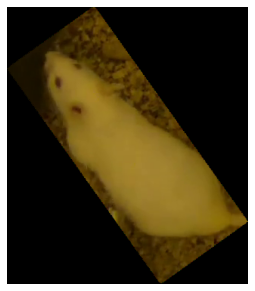

In [22]:
# IF NOT RENDERING, WE CAN VIEW AN IMAGE AT LEAST FOR 
im = white_animal_imgs[120]
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

height, width, depth = im.shape
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)
plt.axis('off')
plt.imshow(im)
plt.show()